In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy
import scipy.stats as st
from scipy.optimize import curve_fit

#Defining Constants
M_z = 91.1880 #GeV/c^2
M_z_unc = 0.0020
M_w = 80.3592 #GeV/c^2
M_w = 0.0133
M_h = 125.20 #GeV/c^2
M_h_unc = 0.11
M_e = 0.51099895000 #MeV/c^2
M_e_unc = 0.0000000015
M_mu = 105.6583755 #MeV/c^2
M_mu_unc = 0.0000023
M_tau = 1776.93 #MeV/c^2
M_tau_unc = 0.09

In [2]:
def momenta(pT, phi, eta):  #defining the function for the four momenta
    px = pT*np.cos(phi)
    py = pT*np.sin(phi)
    pz = pT*np.sinh(eta)
    momenta = [px, py, pz]
    return momenta

def M(E, momenta): #defing the function for the Invariant Mass
    M = np.sqrt(E**2 - (momenta[0]**2 + momenta[1]**2 + momenta[2]**2))
    return M

In [3]:
z2ll_data = np.loadtxt('atlas_z_to_ll.csv', skiprows=1, delimiter=',') #Loading in the ATLAS data

In [4]:
Masses  = np.zeros(5000) #Creating containers for the masses
for i in range(len(z2ll_data)): #Calculating the mass for each lepton pair
    particles = z2ll_data[i] 
    pT_1 = particles[0]
    pT_2 = particles[1]
    eta_1 = particles[2]
    eta_2 = particles[3]
    phi_1 = particles[4]
    phi_2 = particles[5]
    E_1 = particles[6]
    E_2 = particles[7]
    momenta_1 = momenta(pT_1, phi_1, eta_1) #Calculating four-momenta
    momenta_2 = momenta(pT_2, phi_2, eta_2)
    momenta_tot = np.add(momenta_1, momenta_2)
    E_tot = E_1 + E_2
    Masses[i] = M(E_tot, momenta_tot) #Calculating mass and filling the containers

/var/folders/8_/749tf3fx7cd1kh9nfx_3q1640000gn/T/ipykernel_67775/1475066498.py:9: RuntimeWarning: invalid value encountered in sqrt
  M = np.sqrt(E**2 - (momenta[0]**2 + momenta[1]**2 + momenta[2]**2))


Text(0.5, 1.0, 'Histogram of mass distribution')

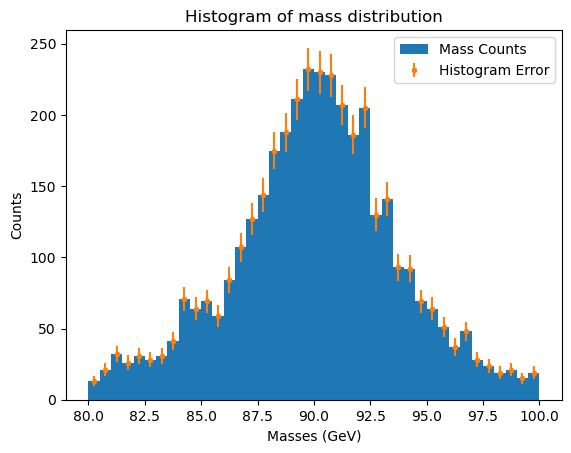

In [5]:
bins = np.linspace(80,100,41) 
figure, ax = plt.subplots(1,1)
n, n_bins, patches = ax.hist(Masses, bins, label = "Mass Counts") #Creating the histogram for the mass distribution, and obtaining the counts for each bin
nerr = np.sqrt(n)

bin_centers = 0.5*(bins[1:] + bins[:-1])

plt.errorbar(bin_centers,n,yerr = nerr,marker = '.',ls  = ' ', label = "Histogram Error" )
ax.legend()
ax.set_xlabel("Masses (GeV)")
ax.set_ylabel("Counts")
ax.set_title("Histogram of mass distribution")

In [6]:
def Breit_Wigner(m, m0, gamma): #Defining the Breit-Wigner Peak function
    D = (1/np.pi)*(gamma/2)/((m-m0)**2 +(gamma/2)**2)
    return (5000/2)*D

p0 = (90,7) #Initial guess
params, covar = curve_fit(f = Breit_Wigner, xdata = bin_centers, ydata = n, sigma = nerr, absolute_sigma = True, p0 = p0) #Fitting the data to the theoretical model

/var/folders/8_/749tf3fx7cd1kh9nfx_3q1640000gn/T/ipykernel_67775/704879597.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figure.tight_layout()


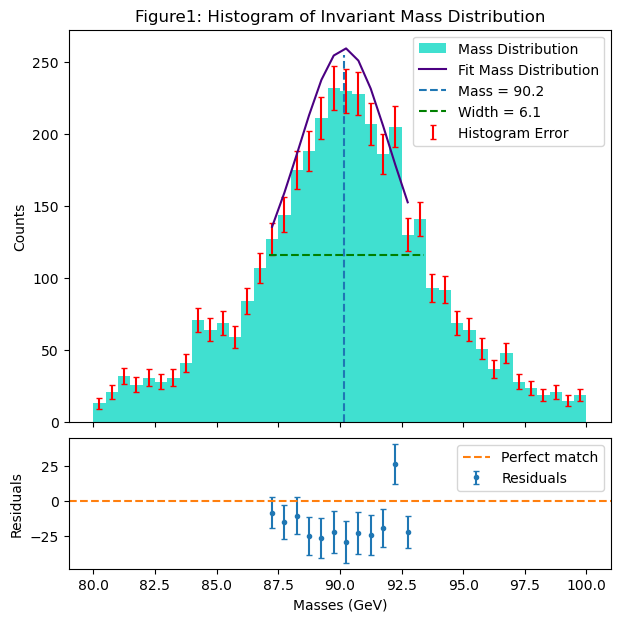

In [7]:
m0_fit = params[0]
gamma_fit = params[1]

mask = (bin_centers > 87) & (bin_centers < 93) 
bins_fit = bin_centers[mask] #Applying mask to limit the bins from 87-93 GeV

n_fit = np.zeros(len(bins_fit)) #Container for fit distribution
for i in range(len(bins_fit)):  #Calculating fit distribution
    n_fit[i] = Breit_Wigner(bins_fit[i],m0_fit,gamma_fit)

n_max = np.max(n)

figure, (ax_top, ax_bottom) = plt.subplots(2,1,figsize = (7,7),sharex = True, gridspec_kw = {"height_ratios": [3,1], "hspace" : 0.06}) #Plotting the histogram and fitted values
ax_top.hist(Masses, bins, label = "Mass Distribution", color = "turquoise")
ax_top.errorbar(bin_centers,n,yerr = nerr,marker = ' ',ls  = ' ', label = "Histogram Error", color = "red", capsize = 2)
ax_top.plot(bins_fit, n_fit, label = "Fit Mass Distribution", color = "indigo")
ax_top.set_ylabel("Counts")
ax_top.set_title("Figure1: Histogram of Invariant Mass Distribution")
ax_top.axvline(params[0], ymin = 0, ymax = 0.935, ls = '--', label = f"Mass = {m0_fit:.1f}")
ax_top.axhline(116, xmin = 0.37, xmax = 0.655 ,ls = '--', c = "green", label = f"Width = {gamma_fit:.1f}")
ax_top.legend()

residuals = n[mask] - n_fit

ax_bottom.errorbar(bins_fit, residuals, yerr = nerr[mask], capsize = 2, ls = ' ', marker = '.', label = "Residuals") #Plotting the residuals
ax_bottom.axhline(0, color = "C1", ls = "--", label = "Perfect match")
ax_bottom.legend()
ax_bottom.set_xlabel("Masses (GeV)")
ax_bottom.set_ylabel("Residuals")
figure.tight_layout()
plt.savefig("Invariant Mass Distribution.png")

In [8]:
chisq =  np.sum(((n_fit-n[mask])/nerr[mask])**2) #Calculating the chi-squared value for the fit
ndof = len(n_fit)-2 #NDOF = 10 since there are 12 bins in desired range, and 2 fitting parameters (m0 and gamma)
red_chisq = chisq/ndof
pvalue = st.chi2.sf(chisq,ndof)
print(f"Chi-squared: {chisq}, Reduced Chi-squared: {red_chisq}, pvalue: {pvalue}")

errs = np.sqrt(np.diag(covar)) #Diagonalising and taking the sqaure root of the covariance matrix to determine the uncertainty in fitted values

m_err = errs[0]

print(f"Best fit mass: {m0_fit} +- {m_err} GeV")


Chi-squared: 30.016345985155866, Reduced Chi-squared: 3.0016345985155866, pvalue: 0.0008513832570854603
Best fit mass: 90.18243550266338 +- 0.05943606853098466 GeV


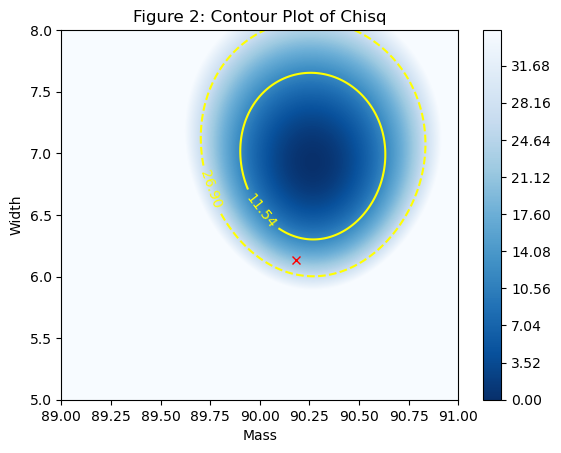

In [9]:
n_bins = 300
chi_map = np.zeros((n_bins, n_bins))
M_range = np.linspace(89,91,n_bins)
Gamma_range = np.linspace(5,8,n_bins)
theory = np.zeros(len(bins_fit))
for i in range(n_bins): #Triple loop to calculate the chisq values for each of the m0 and gamma values in the range. 
    for j in range(n_bins):
        for k in range(len(bins_fit)):
            theory[k] = Breit_Wigner(bins_fit[k], M_range[i], Gamma_range[j])
            chi2 = np.sum((theory-n[mask])**2/nerr[mask]**2)
            chi_map[j,i] = chi2

chi_min = np.min(chi_map)
chi_map = np.clip(chi_map, chi_min, chi_min+35) #Clipping max at 35 to make the plot easy to read
delta_chi_map = np.add(chi_map, -chi_min) #Normalising to ensure lowest value is 0

X,Y = np.meshgrid(M_range,Gamma_range)
fig2, ax = plt.subplots(1,1) #Plotting the contour plot
cs = ax.contourf(X, Y, delta_chi_map,500, cmap = "Blues_r")
cbar = fig2.colorbar(cs, ax=ax)

levels = [11.54,26.90]  #Determined by table for 1 and 3 sigma for ndof = 10
CS = ax.contour(X,Y,delta_chi_map, levels = levels, colors = ["yellow","yellow"], linestyles  =["solid","dashed"])
ax.plot(m0_fit, gamma_fit, "rx")
ax.clabel(CS, levels)
ax.set_xlabel("Mass")
ax.set_ylabel("Width")
ax.set_title("Figure 2: Contour Plot of Chisq")
plt.savefig("Contour Plot of Chisq.png")